In [1]:
from pydantic import BaseModel, Field
from typing import List, Optional, Dict, Any, TypedDict, Annotated

import asyncio
import time
from concurrent.futures import ThreadPoolExecutor

from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.tools import tool
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph.message import add_messages

import nest_asyncio

from IPython.display import Image, SVG, display

In [2]:
@tool
def add_numbers(a: int, b: int) -> int:
    """Return the sum of two integers."""
    return a + b

# Add these new tools to your existing TOOLS list
@tool
def subtract_numbers(a: int, b: int) -> int:
    """Return the difference of two integers (a - b)."""
    return a - b

@tool
def multiply_numbers(a: int, b: int) -> int:
    """Return the product of two integers."""
    return a * b

@tool
def divide_numbers(a: int, b: int) -> float:
    """Return the division of two integers (a / b)."""
    if b == 0:
        return "Cannot divide by zero"
    return a / b

# Update your TOOLS list
TOOLS = [add_numbers, subtract_numbers, multiply_numbers, divide_numbers]
TOOL_MAP = {t.name: t for t in TOOLS}

# Async tool execution functions
async def execute_tool_async(tool_call: dict, tool_map: dict) -> dict:
    """Execute a single tool call asynchronously."""
    name, args, tc_id = tool_call["name"], tool_call["args"], tool_call["id"]
    
    print(f"🔧 Starting async: {name}({args})")
    start_time = time.time()
    
    if name not in tool_map:
        result = f"Error: Tool {name} not found"
        success = False
    else:
        try:
            # Run the tool in a thread pool to avoid blocking
            loop = asyncio.get_event_loop()
            with ThreadPoolExecutor() as executor:
                result = await loop.run_in_executor(
                    executor, 
                    lambda: tool_map[name].invoke(args)
                )
            success = True
        except Exception as e:
            result = f"Error executing {name}: {str(e)}"
            success = False
    
    execution_time = time.time() - start_time
    print(f"✅ Completed {name}: {result} ({execution_time:.2f}s)")
    
    return {
        "tool_call_id": tc_id,
        "name": name,
        "args": args,
        "result": result,
        "success": success,
        "execution_time": execution_time
    }

async def execute_tools_concurrently(tool_calls: list, tool_map: dict) -> list:
    """Execute multiple tool calls concurrently."""
    tasks = [execute_tool_async(tc, tool_map) for tc in tool_calls]
    return await asyncio.gather(*tasks)


In [3]:
class MathProblemState(TypedDict):
    """Math problem solving state using TypedDict for proper LangGraph compatibility."""
    messages: Annotated[List[Any], add_messages]  # LangGraph handles message merging automatically
    problem: Optional[str]  # Original word problem text
    current_step: int  # Current step number in the solution
    calculations: List[Dict[str, Any]]  # History of calculations performed
    final_answer: Optional[str]  # Final calculated answer


class SimpleResponse(BaseModel):
    problem_answer: int
    confidence: float


In [4]:
def validate_message_sequence(messages: List[Any]) -> bool:
    """Validate that tool messages follow AI messages with tool calls."""
    for i, msg in enumerate(messages):
        if isinstance(msg, ToolMessage):
            # Tool message must follow an AI message with tool calls
            if i == 0:
                return False, f"ToolMessage at index {i} cannot be the first message"
            
            prev_msg = messages[i-1]
            if not isinstance(prev_msg, AIMessage):
                return False, f"ToolMessage at index {i} must follow an AIMessage, got {type(prev_msg).__name__}"
            
            if not hasattr(prev_msg, 'tool_calls') or not prev_msg.tool_calls:
                return False, f"ToolMessage at index {i} follows AIMessage without tool_calls"
                
            # Check if the tool call ID matches
            tool_call_ids = [tc['id'] for tc in prev_msg.tool_calls]
            if hasattr(msg, 'tool_call_id') and msg.tool_call_id not in tool_call_ids:
                return False, f"ToolMessage tool_call_id {msg.tool_call_id} not found in previous AIMessage"
    
    return True, "Message sequence is valid"


def debug_messages(messages: List[Any], title: str = "Messages"):
    """Debug helper to print message sequence."""
    print(f"\n🔍 {title}:")
    for i, msg in enumerate(messages):
        msg_type = type(msg).__name__
        content = getattr(msg, 'content', '')[:50] + ('...' if len(getattr(msg, 'content', '')) > 50 else '')
        tool_calls = getattr(msg, 'tool_calls', None)
        tool_call_id = getattr(msg, 'tool_call_id', None)
        
        print(f"  {i}: {msg_type}")
        if content:
            print(f"     Content: {content}")
        if tool_calls:
            print(f"     Tool calls: {len(tool_calls)} calls")
        if tool_call_id:
            print(f"     Tool call ID: {tool_call_id}")

In [ ]:
# System prompt template for math problem solving
SYSTEM_PROMPT = """You are a helpful math tutor. When given a word problem:

1. First, identify what information is given and what needs to be found
2. Break down the problem into clear steps
3. Use the available tools (add_numbers, subtract_numbers, multiply_numbers, divide_numbers) to perform calculations
4. Show your work step by step
5. Provide a clear final answer

Always use tools for calculations rather than doing math in your head. This ensures accuracy and shows the work clearly."""

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0).bind_tools(TOOLS)

def call_llm_with_memory(state: MathProblemState) -> Dict[str, Any]:
    """Enhanced LLM call that considers problem-solving context."""    
    messages = list(state["messages"])  # Convert to list for TypedDict
    
    # Add system message if it's the first interaction
    if len(messages) == 1 and isinstance(messages[0], HumanMessage):
        from langchain_core.messages import SystemMessage
        messages.insert(0, SystemMessage(content=SYSTEM_PROMPT))
    
    ai = llm.invoke(messages)
    return {"messages": [ai]}


def responder(state: MathProblemState) -> Dict[str, Any]:
    """Responder function to provide final answer with structured output."""
    messages = list(state["messages"])
    
    # Add context about calculations if any were performed
    model_messages = messages[-1]

    if isinstance(model_messages, AIMessage):
        context_msg = f"\nProblem solution: {model_messages.content}\n\nPlease provide a clear final answer."
    
    # Use the existing LLM instance - even with tools bound, it won't use them unless needed
    structured_llm = llm.with_structured_output(SimpleResponse)
    result = structured_llm.invoke(context_msg)
    
    # Serialize using Pydantic's built-in method
    return {"messages": [AIMessage(content=str(result))], "final_answer": str(result.problem_answer)}

In [6]:
def call_tools_with_memory(state: MathProblemState) -> Dict[str, Any]:
    """Execute tool calls and track calculations in memory."""
    if not state["messages"]:
        return {"messages": [], "calculations": state["calculations"]}
        
    last = state["messages"][-1]
    
    # Only process if the last message is an AIMessage with tool calls
    if not isinstance(last, AIMessage) or not getattr(last, "tool_calls", []):
        return {"messages": [], "calculations": state["calculations"]}
    
    tool_msgs = []
    new_calculations = list(state["calculations"]) if state["calculations"] else []
    
    for tc in last.tool_calls:
        name, args, tc_id = tc["name"], tc["args"], tc["id"]
        
        # Validate that the tool exists
        if name not in TOOL_MAP:
            result = f"Error: Tool {name} not found"
        else:
            try:
                result = TOOL_MAP[name].invoke(args)
                
                # Track the calculation
                calculation = {
                    "operation": name,
                    "inputs": args,
                    "result": result,
                    "step": len(new_calculations) + 1
                }
                new_calculations.append(calculation)
            except Exception as e:
                result = f"Error executing {name}: {str(e)}"
        
        tool_msgs.append(
            ToolMessage(
                content=f"Result: {result}",
                name=name,
                tool_call_id=tc_id,
            )
        )
    
    return {
        "messages": tool_msgs,
        "calculations": new_calculations,
        "current_step": state["current_step"] + 1
    }

def call_tools_with_memory_async(state: MathProblemState) -> Dict[str, Any]:
    """Execute tool calls asynchronously and track calculations in memory."""
    if not state["messages"]:
        return {"messages": [], "calculations": state["calculations"]}
        
    last = state["messages"][-1]
    
    # Only process if the last message is an AIMessage with tool calls
    if not isinstance(last, AIMessage) or not getattr(last, "tool_calls", []):
        return {"messages": [], "calculations": state["calculations"]}
    
    # Execute tools asynchronously
    async_results = asyncio.run(execute_tools_concurrently(last.tool_calls, TOOL_MAP))
    
    tool_msgs = []
    new_calculations = list(state["calculations"]) if state["calculations"] else []
    
    for result in async_results:
        tool_msgs.append(
            ToolMessage(
                content=f"Result: {result['result']}",
                name=result["name"],
                tool_call_id=result["tool_call_id"],
            )
        )
        
        if result["success"]:
            calculation = {
                "operation": result["name"],
                "inputs": result["args"],
                "result": result["result"],
                "step": len(new_calculations) + 1
            }
            new_calculations.append(calculation)
    
    return {
        "messages": tool_msgs,
        "calculations": new_calculations,
        "current_step": state["current_step"] + 1
    }

In [7]:
def needs_tool(state: MathProblemState) -> str:
    """Determine if tools are needed or if we should provide final response."""
    messages = state["messages"]
    if not messages:
        return END
    
    last = messages[-1]
    has_calls = bool(getattr(last, "tool_calls", []) or [])
    decision = "tools" if has_calls else "responder"
    return decision

In [8]:
def get_math_graph():
    workflow = StateGraph(state_schema=MathProblemState)
    
    workflow.add_node("model", call_llm_with_memory)
    workflow.add_node("tools", call_tools_with_memory_async)
    workflow.add_node("responder", responder)  # Fixed: use the actual responder function

    workflow.set_entry_point("model")
    workflow.add_conditional_edges("model", needs_tool, {"tools": "tools", "responder": "responder"})
    workflow.add_edge("tools", "model")
    workflow.add_edge("responder", END)

    checkpointer = MemorySaver()
    return workflow.compile(checkpointer=checkpointer)


In [9]:
token_tally = {"p": 0, "c": 0, "t": 0}
seen_ids = set()  # to avoid reprinting old messages

def log_step(chunk: dict):
    # Handle both "updates" and "values" stream modes
    if "__end__" in chunk:
        return
    
    # If chunk has node names as keys (updates mode)
    if any(key in ["model", "tools", "__end__"] for key in chunk.keys()):
        for node, state in chunk.items():
            if node == "__end__":
                continue
            _process_messages(node, state)
    else:
        # If chunk is the complete state (values mode)
        _process_messages("STEP", chunk)

def _process_messages(node: str, state):
    messages = state.get("messages", []) if isinstance(state, dict) else []
    msg = ""
    if messages:
        m = messages[-1]

        if isinstance(m, HumanMessage):
            msg = f"[{node.upper()}] USER → {m.content}"
        elif isinstance(m, AIMessage):
            if getattr(m, "tool_calls", None):
                for tc in m.tool_calls:
                    msg += f"[{node.upper()}] MODEL → {tc['name']}(...)\n"
            if m.content:
                msg += f"[{node.upper()}] MODEL → {m.content}"

            usage = (m.response_metadata or {}).get("token_usage", {})
            p, c, t = usage.get("prompt_tokens", 0), usage.get("completion_tokens", 0), usage.get("total_tokens", 0)
            token_tally["p"] += p
            token_tally["c"] += c
            token_tally["t"] += t
            if t > 0:
                msg += f" ⎯ tokens: {p}/{c}/{t}"

        elif isinstance(m, ToolMessage):
            preview = m.content[:80] + ("…" if isinstance(m.content, str) and len(m.content) > 80 else "")
            msg += f"[{node.upper()}] TOOL ← {m.name}: {preview}"

    if msg:
        print(msg)


In [10]:
nest_asyncio.apply()

In [11]:
graph = get_math_graph()

problem = """
John starts with $50. 
He buys 3 apples at $2 each and 2 oranges at $3 each.
Then he finds $5 on the ground.
How much money does John have left?
"""

# Reset token tally and seen IDs for fresh start
token_tally = {"p": 0, "c": 0, "t": 0}
seen_ids = set()

# Create initial state using TypedDict (no more Pydantic!)
initial_state: MathProblemState = {
    "messages": [HumanMessage(content=f"Solve this step by step: {problem}")],
    "problem": problem,
    "steps": [],
    "current_step": 0,
    "calculations": [],
    "final_answer": None
}

# No more model_dump() needed!
config = {"configurable": {"thread_id": "fresh_math_session"}}

# Pass the TypedDict directly to LangGraph
for chunk in graph.stream(initial_state, config=config, stream_mode="values"):
    log_step(chunk)

[STEP] USER → Solve this step by step: 
John starts with $50. 
He buys 3 apples at $2 each and 2 oranges at $3 each.
Then he finds $5 on the ground.
How much money does John have left?

[STEP] MODEL → multiply_numbers(...)
[STEP] MODEL → multiply_numbers(...)
[STEP] MODEL → Let's break down the problem step by step.

1. **Identify the information given:**
   - John starts with $50.
   - He buys 3 apples at $2 each.
   - He buys 2 oranges at $3 each.
   - He finds $5 on the ground.

2. **What needs to be found:**
   - The total amount of money John has left after his purchases and finding money.

3. **Calculate the total cost of the apples:**
   - Cost of 1 apple = $2
   - Number of apples = 3
   - Total cost of apples = 3 * 2

4. **Calculate the total cost of the oranges:**
   - Cost of 1 orange = $3
   - Number of oranges = 2
   - Total cost of oranges = 2 * 3

5. **Calculate the total cost of fruits:**
   - Total cost of fruits = Total cost of apples + Total cost of oranges

6. **Cal

In [12]:
chunk["final_answer"]

'43'

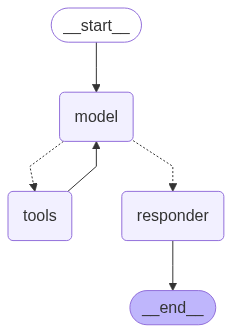

In [13]:
Image(graph.get_graph().draw_mermaid_png())


In [14]:
chunk['messages'][-1]

AIMessage(content='problem_answer=43 confidence=0.95', additional_kwargs={}, response_metadata={}, id='24a6bc82-5854-41d0-b2af-585aa074b085')